## Regression Intro

In [216]:
import pandas as pd
import yfinance as yf
import math
import numpy as np
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime
import pickle



In [217]:
df = yf.download('GOOGL', start='2010-01-01', end='2024-12-31')
print(df.head())

# high minus low percent
df["HL_PCT"] = (df['High'] - df['Low']) / df['Low'] * 100

# daily percent change
df["PCT_change"] = (df['Close'] - df['Open']) / df['Open'] * 100

print(df.head())

df = df[['Close','HL_PCT',"PCT_change",'Volume']]
print(df.head())

forecast_col = 'Close'
df.fillna(-99999, inplace=True) # it helps to keep data as an outlier instead of get rid of the data points
forecast_out = int(math.ceil(0.01*len(df)))

df['label'] = df['Close'].shift(-forecast_out)
df.dropna(inplace=True)
print(df.tail(10))

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker          GOOGL      GOOGL      GOOGL      GOOGL      GOOGL
Date                                                             
2010-01-04  15.609804  15.678545  15.547291  15.614785   78169752
2010-01-05  15.541064  15.636953  15.480045  15.620515  120067812
2010-01-06  15.149293  15.587637  15.101972  15.587637  158988852
2010-01-07  14.796625  15.192631  14.760512  15.177686  256315428
2010-01-08  14.993881  15.024515  14.672344  14.744323  188783028
Price           Close       High        Low       Open     Volume    HL_PCT   
Ticker          GOOGL      GOOGL      GOOGL      GOOGL      GOOGL             
Date                                                                          
2010-01-04  15.609804  15.678545  15.547291  15.614785   78169752  0.844225  \
2010-01-05  15.541064  15.636953  15.480045  15.620515  120067812  1.013611   
2010-01-06  15.149293  15.587637  15.101972  15.587637  158988852  3.215908  

In [218]:
# Data Preprocessing

X = np.array(df[['Close','HL_PCT',"PCT_change",'Volume']])
y = np.array(df['label'])

X = preprocessing.scale(X)
X = X[:-forecast_out+1]
X_lately = X[-forecast_out:]
y = y[:-forecast_out+1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
# Train Model

lm = LinearRegression(n_jobs=-1)
# lm = LinearRegression()
svm_model_line = SVR()
svm_model_poly = SVR(kernel="poly")

lm.fit(X_train, y_train)
svm_model_line.fit(X_train, y_train)
svm_model_poly.fit(X_train, y_train)

with open("linearregression.pickle",'wb') as f:
    pickle.dump(lm, f)
with open("SVMlinear.pickle","wb") as f:
    pickle.dump(svm_model_line, f)
with open("SVMpoly.pickle","wb") as f:
    pickle.dump(svm_model_poly, f)

In [ ]:
# Calling Saved Model

pickle_lm = open('linearregression.pickle','rb')
lm = pickle.load(pickle_lm)
pickle_SVMlinear = open('SVMlinear.pickle','rb')
lm = pickle.load(pickle_SVMlinear)
pickle_SVMpoly = open('SVMpoly.pickle','rb')
lm = pickle.load(pickle_SVMpoly)

In [220]:
accuracy_line = lm.score(X_test, y_test)
accuracy_svm_line = svm_model_line.score(X_test, y_test)
accuracy_svm_poly = svm_model_poly.score(X_test, y_test)

print(accuracy_line, accuracy_svm_line, accuracy_svm_poly, forecast_out)

0.6265653967022284 0.9438585388617481 0.6265653967022284 38


In [221]:
forecast_set = lm.predict(X_lately)
print(forecast_set)

[282.08916138 259.81563932 218.47476953 265.96775931 203.50737127
 226.75319382 234.18605203 249.90240828 260.66073495 216.16091964
 329.6048443  165.68868521 205.00059934 202.22283379 244.49361021
 211.37124091 201.27292392 205.34378412 177.79573402 212.96095691
 213.85873557 213.98062887 205.77851765 233.23885921 217.02469106
 224.45706552 213.82391757 224.57818967 243.65748317 195.469517
 214.28528732 179.17777125 189.18287898 261.33082251 196.57054472
 147.34483622 166.40573612 158.66824599]


In [222]:
df["Forecast"] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = next_unix
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]
    


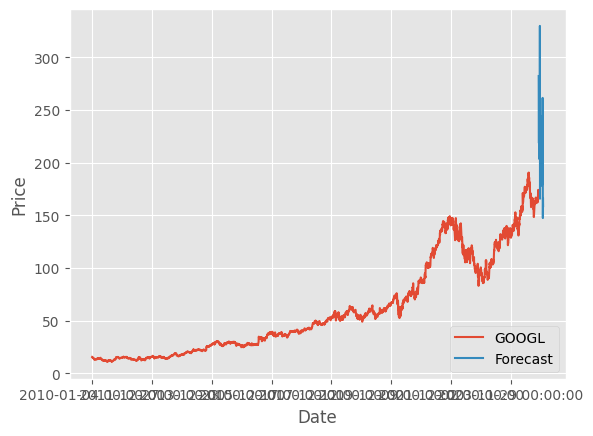

In [223]:
df['Close'].plot()
df["Forecast"].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()